# **Setup**

In [ ]:
%run '/content/drive/MyDrive/development/utils.ipynb'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import pandas as pd
working_directory = '/content/drive/MyDrive/development/models/model-7s'
test_dir = '/content/drive/MyDrive/development/datasets/test/test-3'
image_dir = os.path.join(test_dir,'images')
results_csv_path = os.path.join(working_directory,'testing/run/label.csv')

# **Inference**

In [ ]:
!python /content/drive/MyDrive/development/models/model-7s/run.py \
  --source /content/drive/MyDrive/development/datasets/test/test-4/images \
  --weights /content/drive/MyDrive/development/models/model-7/leaves_detection_and_classfication/run8/weights/best.pt \
  --project /content/drive/MyDrive/development/models/model-7s/testing \
  --name run


Processing image: /content/drive/MyDrive/development/datasets/test/test-3/images/image_0_20231225-120225.jpg
Namespace(weights=['/content/drive/MyDrive/development/models/model-7/leaves_detection_and_classfication/run8/weights/best.pt'], source='temp_parts/part_1.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='temp_parts', name='outputs', exist_ok=True, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.3.0+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

fatal: not a git repository (or any of the parent directories): .git
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarn

In [ ]:
import os
import pandas as pd

# Directory containing the .txt files
directory = '/content/drive/MyDrive/development/models/model-7s/testing/run/labels'

# Prepare lists to hold data
data = {
    'image_id': [],
    'bbox': [],
    'prediction': [],
    'score': []  # Add a list to hold confidence scores
}

# Actual dimensions of the images (4K resolution)
width, height = 1024, 1024

# Class mapping from numbers to labels
class_mapping = {0: 'Healthy', 1: 'Sick'}

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)

        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()  # Assuming space-separated values
                if len(parts) == 6:  # Update to expect 6 parts, including the score
                    image_id = filename[:-4] + '.jpg'  # Change .txt to .jpg in the image ID
                    prediction_index = int(parts[0])
                    prediction_label = class_mapping.get(prediction_index, 'Unknown')  # Map class ID to label
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    bbox_width = float(parts[3]) * width
                    bbox_height = float(parts[4]) * height
                    xmin = x_center - (bbox_width / 2)
                    ymin = y_center - (bbox_height / 2)
                    xmax = x_center + (bbox_width / 2)
                    ymax = y_center + (bbox_height / 2)
                    score = float(parts[5])  # Parse confidence score

                    # Store data
                    data['image_id'].append(image_id)
                    data['bbox'].append([xmin, ymin, xmax, ymax])
                    data['prediction'].append(prediction_label)
                    data['score'].append(score)  # Append confidence score to the list

# Create a DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_path = '/content/drive/MyDrive/development/models/model-7s/testing/run/label.csv'
df.to_csv(csv_path, index=False)



# **Utilising Matching and MAP function**

In [ ]:

ground_truth = pd.read_csv(os.path.join(test_dir, 'label.csv'))
predictions = pd.read_csv(results_csv_path)

# Generate label-to-class mapping
all_labels = pd.concat([ground_truth['Class'], predictions['prediction']]).unique()
label_to_class = {label: idx for idx, label in enumerate(all_labels)}

def matching_and_map_class(groundtruth, predictions, label_to_class, iou_threshold=0.5, debug=False):
    """Match predictions to ground truths based on IoU and compute mAP for both detection and classification."""
    match_dict, bbox_gt_formatted, bbox_preds_formatted,iou = match_bboxes(groundtruth, predictions, label_to_class, iou_threshold, debug)
    class_map_score = compute_map_score(groundtruth, predictions, label_to_class, match_dict, bbox_gt_formatted, bbox_preds_formatted, debug)
    return class_map_score

# Calculate mAP for each image
mAP_results = []
for image_id in predictions['image_id'].unique():
    gt_data = ground_truth[ground_truth['image_id'] == image_id]
    pr_data = predictions[predictions['image_id'] == image_id]

    # Format data for mAP calculation
    gt_formatted = [{'box': convert_bbox(gt['bbox']), 'label': gt['Class']} for index, gt in gt_data.iterrows()]
    pr_formatted = [{'box': convert_bbox(pr['bbox']), 'label': pr['prediction'], 'score': pr['score']} for index, pr in pr_data.iterrows()]

    # Compute mAP for the current image
    mAP_results.append({
        'image_id': image_id,
        'class_map_score': matching_and_map_class(gt_formatted, pr_formatted, label_to_class, iou_threshold=0.5, debug=False)
    })

# Print or process the mAP results as needed
for result in mAP_results:
    print(f"Image ID: {result['image_id']}, Classification mAP: {result['class_map_score']}")

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


Image ID: image_0_20231225-120225.jpg, Classification mAP: 0.5
Image ID: image_0_20240301-060002.jpg, Classification mAP: 0.5657109022140503
Image ID: image_0_20240304-180305.jpg, Classification mAP: 0.5993684530258179
Image ID: image_0_20240311-220709.jpg, Classification mAP: 0.6425398588180542
Image ID: image_2_20240329-140502.jpg, Classification mAP: 0.5
Image ID: image_2_20240331-120300.jpg, Classification mAP: 0.5
Image ID: image_2_20240405-140501.jpg, Classification mAP: 0.5
Image ID: image_2_20240405-140602.jpg, Classification mAP: 0.5
Image ID: image_0_20240327-060005.jpg, Classification mAP: 0.5
Image ID: image_0_20240325-060001.jpg, Classification mAP: 0.5
Image ID: image_0_20240322-060004.jpg, Classification mAP: 0.5
Image ID: image_0_20240302-180009.jpg, Classification mAP: 0.5813986659049988
Image ID: image_0_20240312-060001.jpg, Classification mAP: 0.6405870914459229
Image ID: image_1_20240130-100901.jpg, Classification mAP: 0.6889514923095703
Image ID: image_1_20240221-2

In [ ]:
import numpy as np

# Generate ranges for thresholds
score_thresholds = np.arange(0.2, 1.1, 0.1)
iou_thresholds = np.arange(0.5, 1.05, 0.05)

def matching_and_map_class(groundtruth, predictions, label_to_class, iou_threshold=0.5, debug=False):
    """Match predictions to ground truths based on IoU and compute mAP for both detection and classification."""
    match_dict, bbox_gt_formatted, bbox_preds_formatted,_ = match_bboxes(groundtruth, predictions, label_to_class, iou_threshold, debug)
    class_map_score = compute_map_score(groundtruth, predictions, label_to_class, match_dict, bbox_gt_formatted, bbox_preds_formatted, debug)
    return class_map_score


# Define a function to compute mAP
def compute_map_for_thresholds(predictions, ground_truth, score_th, iou_th):
    mAP_results = []
    for image_id in predictions['image_id'].unique():
        gt_data = ground_truth[ground_truth['image_id'] == image_id]
        pr_data = predictions[predictions['image_id'] == image_id]

        # Filter predictions by the score threshold
        pr_data = pr_data[pr_data['score'] >= score_th]

        # Format data for mAP calculation
        gt_formatted = [{'box': convert_bbox(gt['bbox']), 'label': gt['Class']} for index, gt in gt_data.iterrows()]
        pr_formatted = [{'box': convert_bbox(pr['bbox']), 'label': pr['prediction'], 'score': pr['score']} for index, pr in pr_data.iterrows()]

        # Compute mAP for the current image
        result = matching_and_map_class(gt_formatted, pr_formatted, label_to_class, iou_threshold=iou_th)
        mAP_results.append({
            'image_id': image_id,
            'score_threshold': score_th,
            'iou_threshold': iou_th,
            'mAP': result
        })
    return mAP_results

# Iterate over each combination of score and IoU threshold and compute mAP
all_results = []
for score_th in score_thresholds:
    for iou_th in iou_thresholds:
        results = compute_map_for_thresholds(predictions, ground_truth, score_th, iou_th)
        all_results.extend(results)

# Optionally, convert results to a DataFrame for better handling
results_df = pd.DataFrame(all_results)
results_df['mAP'] = results_df['mAP'].astype(float)
print(results_df)



                         image_id  score_threshold  iou_threshold       mAP
0     image_0_20231225-120225.jpg              0.2            0.5  0.500000
1     image_0_20240301-060002.jpg              0.2            0.5  0.565711
2     image_0_20240304-180305.jpg              0.2            0.5  0.599368
3     image_0_20240311-220709.jpg              0.2            0.5  0.642540
4     image_2_20240329-140502.jpg              0.2            0.5  0.500000
...                           ...              ...            ...       ...
1480  image_0_20240322-060004.jpg              1.0            1.0  0.500000
1481  image_0_20240302-180009.jpg              1.0            1.0  0.500000
1482  image_0_20240312-060001.jpg              1.0            1.0  0.500000
1483  image_1_20240130-100901.jpg              1.0            1.0  0.500000
1484  image_1_20240221-220708.jpg              1.0            1.0  0.500000

[1485 rows x 4 columns]


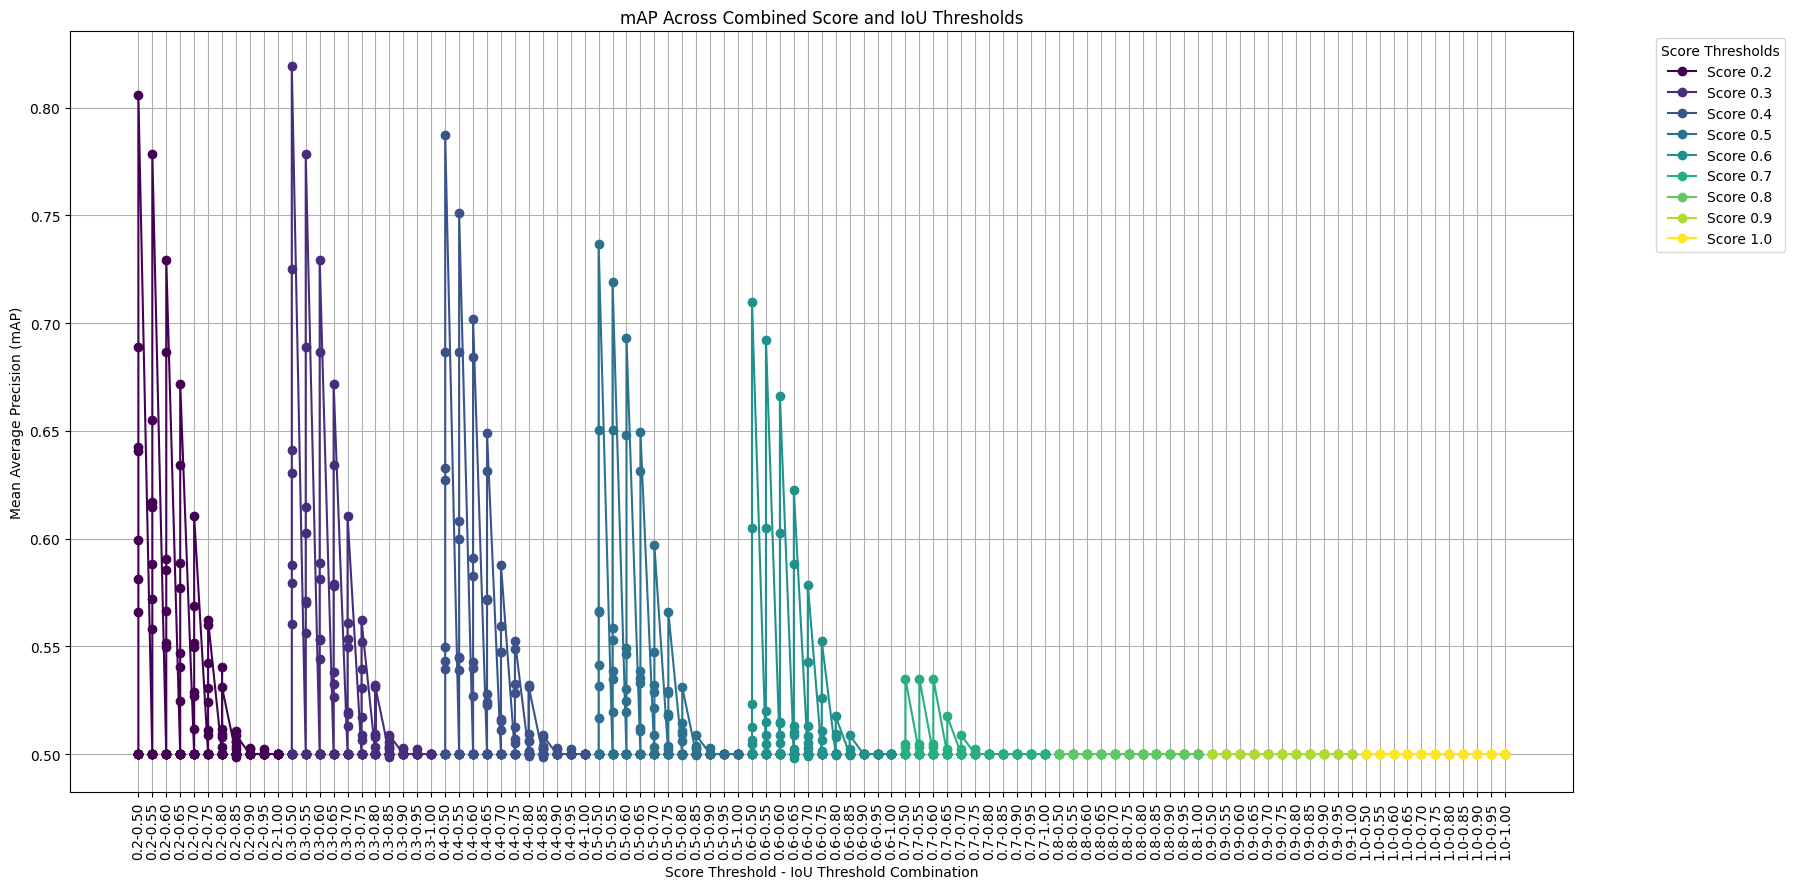

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Plotting
plt.figure(figsize=(18, 9))  # Increase figure size for better clarity
results_df['Threshold Combination'] = results_df.apply(lambda row: f"{row['score_threshold']:.1f}-{row['iou_threshold']:.2f}", axis=1)
sorted_df = results_df.sort_values(by=['score_threshold', 'iou_threshold'])
unique_scores = sorted_df['score_threshold'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_scores)))  # Use a colormap for better color distinction

for score, color in zip(unique_scores, colors):
    subset = sorted_df[sorted_df['score_threshold'] == score]
    # Plot only every nth point to reduce clutter, if needed
    nth = 1  # Change this value to skip points
    plt.plot(subset['Threshold Combination'][::nth], subset['mAP'][::nth], '-o', label=f'Score {score:.1f}', color=color)

plt.xlabel('Score Threshold - IoU Threshold Combination')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('mAP Across Combined Score and IoU Thresholds')
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.legend(title="Score Thresholds", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


# **Annotate the predictions**

In [ ]:
import os
import cv2
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil

score_threshold = 0
iou_threshold = 0

target_width = 1024
target_height = 1024
# Paths to the CSV files
predictions_path = os.path.join(working_directory, 'testing/run/label.csv')
ground_truth_path = os.path.join(test_dir, 'label.csv')

# Load the CSV files
predictions_df = pd.read_csv(predictions_path)
ground_truth_df = pd.read_csv(ground_truth_path)

# Process the dataframes
predictions_df = process_bboxes(predictions_df)
ground_truth_df = process_bboxes(ground_truth_df)
labels = ['Healthy', 'Sick', 'Back ground']


# Annotate images
def annotate_images(predictions_df, ground_truth_df, mAP_results, image_dir, output_dir, score_threshold=score_threshold, iou_threshold=iou_threshold, target_width=target_width, target_height=target_height):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #labels = ['Healthy', 'Sick', 'Back ground']
    label_to_class = {'Healthy': 0, 'Sick': 1, 'Back ground': 2}
    overall_cm = np.zeros((len(labels), len(labels)), dtype=int)

    for map_result in mAP_results:
        image_id = map_result['image_id']
        mAP_score = map_result['class_map_score']
        image_path = os.path.join(image_dir, f"{image_id}")
        image = cv2.imread(image_path)
        if image is None:
            logging.warning(f"Failed to load image: {image_path}")
            continue

        base_height, base_width = image.shape[:2]
        pred_group = predictions_df[(predictions_df['image_id'] == image_id) & (predictions_df['score'] >= score_threshold)]
        ground_truth_group = ground_truth_df[ground_truth_df['image_id'] == image_id]

        # Convert predictions and ground truth to list of dictionaries
        groundtruth = [{'box': convert_bbox(gt_row['bbox']), 'label': gt_row['Class']} for gt_idx, gt_row in ground_truth_group.iterrows()]
        predictions = [{'box': convert_bbox(pred_row['bbox']), 'label': pred_row['prediction'], 'score': pred_row['score']} for pred_idx, pred_row in pred_group.iterrows()]

        # Perform matching
        match_dict, bbox_gt_formatted, bbox_preds_formatted,iou = match_bboxes(groundtruth, predictions, label_to_class, iou_threshold)

        y_true = []
        y_pred = []

        for gt_idx, gt_row in enumerate(groundtruth):
            gt_label = gt_row['label']
            if gt_idx in match_dict and match_dict[gt_idx] is not None:
                pred_idx = match_dict[gt_idx]
                pred_label = predictions[pred_idx]['label']
                y_true.append(gt_label)
                y_pred.append(pred_label)
            else:
                y_true.append(gt_label)
                y_pred.append('Back ground')

        for pred_idx, pred_row in enumerate(predictions):
            if pred_idx not in match_dict.values():
                y_true.append('Back ground')
                y_pred.append(pred_row['label'])

        # Draw all ground truth boxes
        for gt in groundtruth:
            scaled_gt_bbox = scale_bbox(gt['box'], base_width, base_height, target_width, target_height)
            draw_solid_rectangle(image, scaled_gt_bbox, gt['label'])

        # Draw all prediction boxes
        for pred in predictions:
            scaled_pred_bbox = scale_bbox(pred['box'], base_width, base_height, target_width, target_height)
            draw_dotted_rectangle(image, scaled_pred_bbox, pred['label'], pred['score'])

        # Generate confusion matrix for the image
        cm_df = generate_image_confusion_matrix(y_true, y_pred, labels)
        overall_cm += cm_df.values
        logging.info(f"Confusion Matrix for {image_id}: \n{cm_df}")

        metrics = calculate_metrics(cm_df)

        final_image_path = os.path.join(output_dir, f"{image_id}")
        draw_confusion_matrix_and_metrics_on_image(image, cm_df.values, labels, metrics,800, final_image_path, score_threshold,iou_threshold)

        final_image_path = os.path.join(output_dir, f"{image_id}")
        cv2.imwrite(final_image_path, image)
        logging.info(f"Final annotated image saved to {final_image_path}")

    return overall_cm, metrics, cm_df



if __name__ == '__main__':
    predictions_df = pd.read_csv(os.path.join(working_directory, 'testing/run/label.csv'))
    ground_truth_df = pd.read_csv(os.path.join(test_dir, 'label.csv'))
    image_dir = os.path.join(test_dir, 'images/')
    output_base_dir = os.path.join(working_directory, 'testing/')

    # Directory where parameter results will be stored
    parameters_dir = os.path.join(output_base_dir, "parameters")

    # Clear existing contents in the parameters directory before starting new processing
    if os.path.exists(parameters_dir):
        clear_directory(parameters_dir)
    else:
        os.makedirs(parameters_dir)  # Create the directory if it does not exist

    # Specify IoU and score thresholds as [start, end, step size]
    iou_thresholds = [0.2, 1, 0.2]
    score_thresholds = [0.2, 1, 0.2]
    iou_range = np.arange(*iou_thresholds)
    score_range = np.arange(*score_thresholds)

    for iou_threshold in iou_range:
        for score_threshold in score_range:
            main_output_dir = os.path.join(parameters_dir, f"param_iou{iou_threshold:.1f}_cscore{score_threshold:.1f}")
            output_dir = os.path.join(main_output_dir, 'annotated_images')
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            overall_cm, metrics, cm_df = annotate_images(predictions_df, ground_truth_df, mAP_results, image_dir, output_dir, score_threshold, iou_threshold, target_width, target_height)
            overall_cm_df = pd.DataFrame(overall_cm, index=labels, columns=labels)
            metrics_all = calculate_metrics(overall_cm_df)
            combined_output_path = os.path.join(main_output_dir, 'summary.jpeg')
            save_combined_confusion_matrix_and_metrics(overall_cm_df, metrics_all, combined_output_path)